# Punctuation Restoration

Students:

- Ayoub HAMMAL

- Quentin LE TELLIER

- Junior Cédric TONGA

Datasets:

- Processed dataset: https://www.kaggle.com/datasets/ayoubhammal/processed-dataset-bookcorpus

- CBOW embedding: https://www.kaggle.com/datasets/ayoubhammal/cbow-embedding

## Introduction

Usually, automatic speech recognition systems output texts without any punctuation marks. The lack of punctuations in those outputs affects readability, which is in conflict with speech-to-text objectives. Our goal is to build a deep learning model that restores punctuation marks in texts where those marks are missing.

In this report, we present a complete pipeline to solve this problem, from preprocessing of the plain english text, to the training and evaluation steps of our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import Tensor
from torch.nn.modules.loss import _Loss
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset

import nltk

from gensim.models.keyedvectors import KeyedVectors
from gensim.parsing.preprocessing import *

from transformers import BertTokenizer
from transformers import AlbertTokenizer
from transformers import DistilBertTokenizer
from transformers import RobertaTokenizer
from transformers import BertModel
from transformers import AlbertModel
from transformers import DistilBertModel
from transformers import RobertaModel

from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from datasets import load_dataset

from wrapper import Wrapper
from dataset import *
from metrics_collection import accuracy_metric, f1_metric, masked_accuracy, masked_f1

from collections import OrderedDict, Counter
import time
import os

Flair is a NLP library based on PyTorch. We will use it later to predict part-of-speech tags.

In [2]:
!pip install flair==0.11
from flair.models import SequenceTagger
from flair.data import Sentence

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.9/401.9 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 54.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14759 sha256=a7183f793bde6025c14262e6ed969798e66acb44a1df8af5b43

In [3]:
dataset_path = "/kaggle/input/processed-dataset-bookcorpus/"

# Visualization

#### Data and embedding model loading

Here, we load a part of the dataset, already formated. The file "text_bookcorpus.txt" contains the 200.000 first sentences of the dataset

In [4]:
with open("/kaggle/input/cbow-embedding/text_bookcorpus.txt", "r") as file:
    text_dataset = file.read()

#load a pretrained cbow embedding, trained on the bookcorpus
cbow_trained = KeyedVectors.load(
    "/kaggle/input/cbow-embedding/embedding/word2vec_bookcorpus.model"
)

In [5]:
#Dictionnary mapping each punctuation mark to its corresponding label
punkt_symbol2token = {
    "!": "[EXCLAMATION]",
    '"': "[DOUBLE_QUOTATION]",
    "'": "[SINGLE_QUOTATION]",
    "(": "[OPEN_PARENTHESIS]",
    ")": "[CLOSE_PARENTHESIS]",
    ",": "[COMMA]",
    "-": "[DASH]",
    ".": "[PERIOD]",
    ":": "[COLUMN]",
    ";": "[SEMICOLUMN]",
    "?": "[QUESTION]",
    "`": "[BACKTICK]",
}

#Dictionnary mapping each label to its corresponding punctuation mark
punkt_symbol2token_cleaned = {
    "!": "[EXCLAMATION]",
    '"': "[DOUBLE_QUOTATION]",
    ",": "[COMMA]",
    ".": "[PERIOD]",
    ":": "[COLUMN]",
    ";": "[SEMICOLUMN]",
    "?": "[QUESTION]",
}

<AxesSubplot:title={'center':'Punctuation marks frequencies'}>

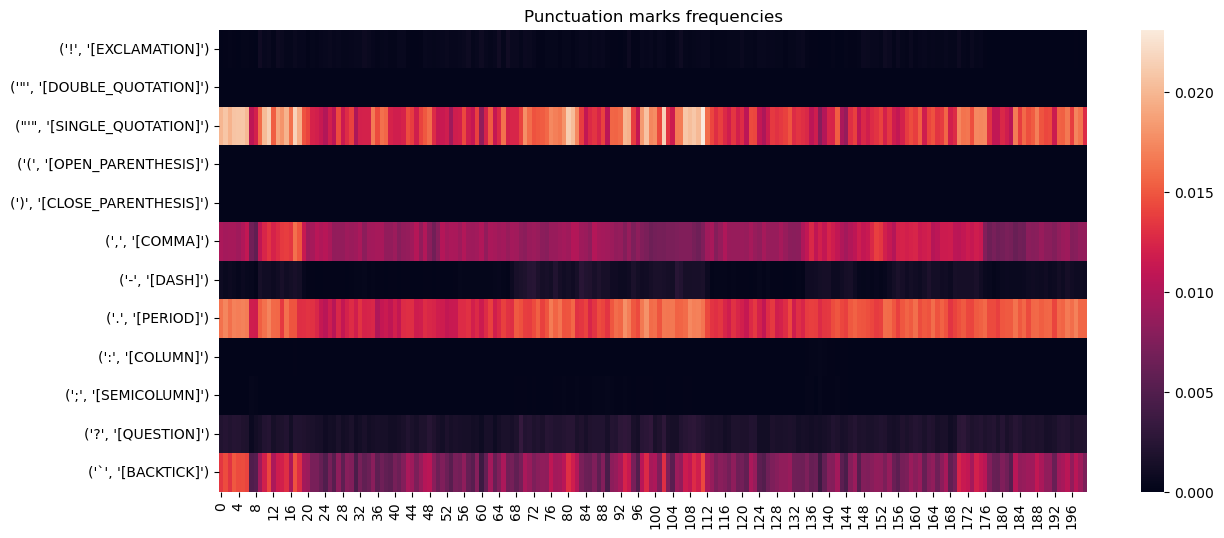

In [6]:
# Plot the frequency heatmap of the different punctuation marks, by batches of characters
nb_batch=200


def get_char_freq(sample_size, char, corpus_text):
    freqs = []
    i = 0
    while i < len(corpus_text):
        string = corpus_text[i : i + sample_size]
        freqs.append(string.count(char) / sample_size)
        i += sample_size
    return freqs


sample_size = round(len(text_dataset) / nb_batch)

punkts_freqs = []
for punkt in punkt_symbol2token:
    punkts_freqs.append(get_char_freq(sample_size, punkt, text_dataset))

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title("Punctuation marks frequencies")
sns.heatmap(punkts_freqs, yticklabels=punkt_symbol2token.items())

#### Punctuation marks frequency plotting all-mixed

We can observe some slight disparities in the frequency of the punctuation marks along the dataset. The range of frequencies is between 0.020 and 0.030 approximately.

<AxesSubplot:title={'center':'Punctuation marks frequencies - all mixed'}>

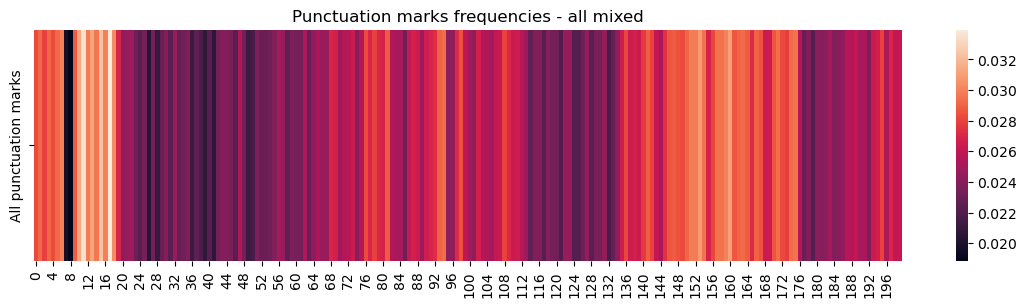

In [7]:
# Plot the frequency heatmap of all the punctuation marks, all mixed

punkts_freqs_reduced = []
for punkt in punkt_symbol2token_cleaned:
    punkts_freqs_reduced.append(get_char_freq(sample_size, punkt, text_dataset))

all_punkts_freqs = np.array(punkts_freqs_reduced).sum(axis=0).reshape(-1, 1).T

fig, ax = plt.subplots(figsize=(14, 3))
ax.set_title("Punctuation marks frequencies - all mixed")
sns.heatmap(all_punkts_freqs, yticklabels=["All punctuation marks"])

#### Most frequent words preceding punctuation marks

Some words are often situated before a punctuation mark. For example, in the batch studied, the word "said" appears 10.000 times and is situated just before a punctuation mark 4.500 times !

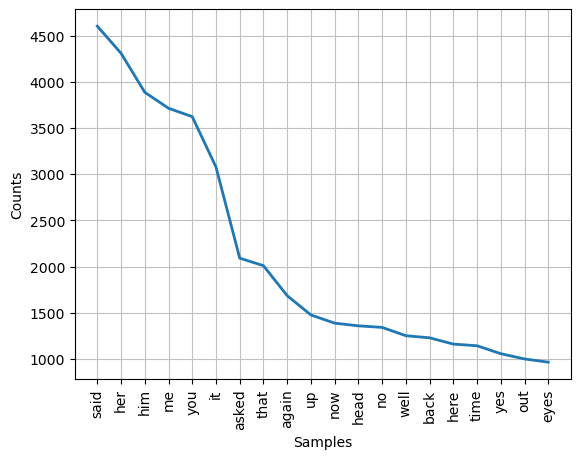

In [8]:
# Plot of the most frequent words preceding a punctuation mark by occurences

tokens_w_punkt = nltk.word_tokenize(text_dataset)

words_preceding_punkt = []
for idx, token in enumerate(tokens_w_punkt[1:]):
    if token in list(punkt_symbol2token.keys()):
        words_preceding_punkt.append(tokens_w_punkt[idx])

words_preceding_punkt_freqs = nltk.FreqDist(words_preceding_punkt)
words_preceding_punkt_freqs.plot(20)

#### Most frequent words and embedding visualization

Here, we study the occurences of words in the dataset, without considering punctuation marks.

In [9]:
# We preprocess the data by removing punctuation marks, and count the number of occurences of each word
tokens = preprocess_string(text_dataset)
counter = Counter(tokens)
top_words_count = counter.most_common(20)

In [10]:
top_words = []
top_words_embed = []
top_words_occ = []
for tuple in top_words_count:
    if tuple[0] in cbow_trained:
        top_words.append(tuple[0])
        top_words_embed.append(cbow_trained[tuple[0]])
        top_words_occ.append(tuple[1])

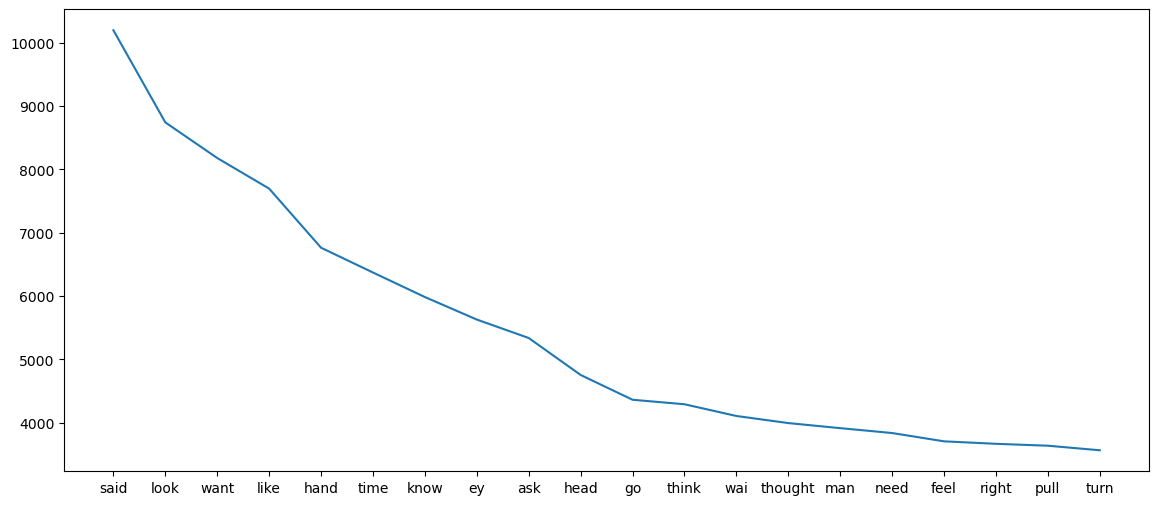

In [11]:
# Plot of the most common words in the dataset

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(top_words, top_words_occ)

#### Embedding visualisation for the most frequent words

As expected, words with a similar or close meaning are close on the plot. For exemple, parts of human body such as "hand" and "head" are pretty close from each other.
Other examples: "ask" and "said", "need" and "want", "feel" and "thought", "think" and "know". This observation is in adequacy with the goal of word embedding: representing each word with a multidimensional vector taking into account meaning proximity between them. 

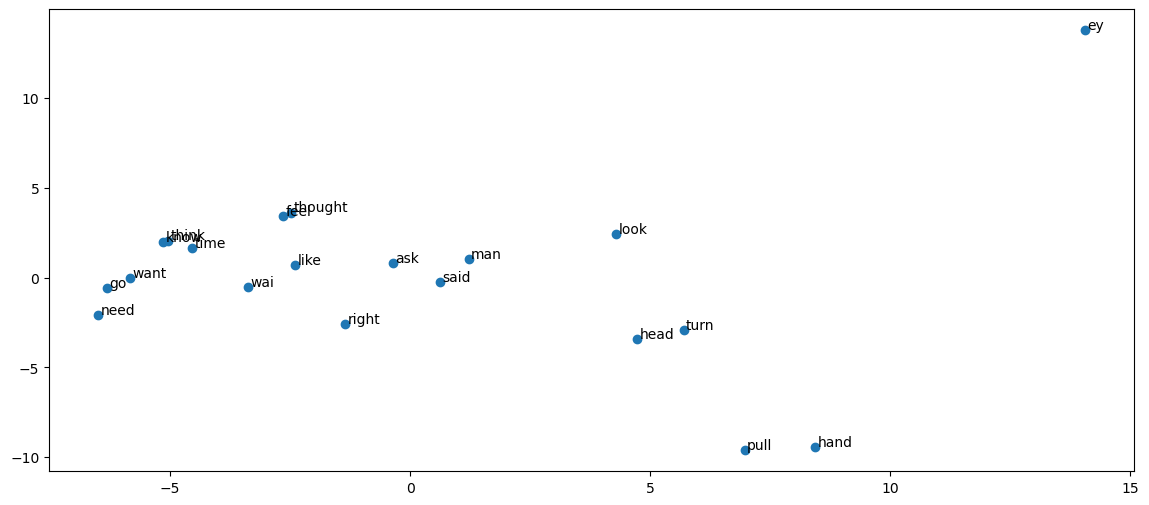

In [12]:
top_words_embed = np.asarray(top_words_embed)
top_words = np.asarray(top_words)

#PCA reduction of word embedding
reduced = PCA(n_components=2).fit_transform(top_words_embed)

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(reduced[:, 0], reduced[:, 1])

for i, txt in enumerate(top_words):
    ax.annotate(txt, (reduced[i, 0] + 0.05, reduced[i, 1] + 0.05))

#### Grammatical tagging

Here we use the flair library and load a pretrained model for part-of-speech tagging on the first 10.000 words of the dataset

In [13]:
tagger = SequenceTagger.load("flair/upos-english-fast")
sentence = Sentence(words_preceding_punkt[:10000])
tagger.predict(sentence)

/opt/conda/lib/python3.7/site-packages/huggingface_hub/file_download.py:632: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


2023-03-06 09:03:09,219 loading file /root/.flair/models/upos-english-fast/b631371788604e95f27b6567fe7220e4a7e8d03201f3d862e6204dbf90f9f164.0afb95b43b32509bf4fcc3687f7c64157d8880d08f813124c1bd371c3d8ee3f7
2023-03-06 09:03:09,335 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, INTJ, PUNCT, VERB, PRON, NOUN, ADV, DET, ADJ, ADP, NUM, PROPN, CCONJ, PART, AUX, X, SYM, <START>, <STOP>


In [14]:
gramatical_classes = []
for word in sentence:
    gramatical_classes.append(word.get_label("pos").to_dict()["value"])

counter = Counter(gramatical_classes)
top_gramatical_classes = counter.most_common(10)
top_classes = []
top_classes_count = []

for tuple in top_gramatical_classes:
    top_classes.append(tuple[0])
    top_classes_count.append(tuple[1])

We can observe that nouns is the most frequent grammatical class of the words preceding punctuations marks, followed by verbs and pronouns.

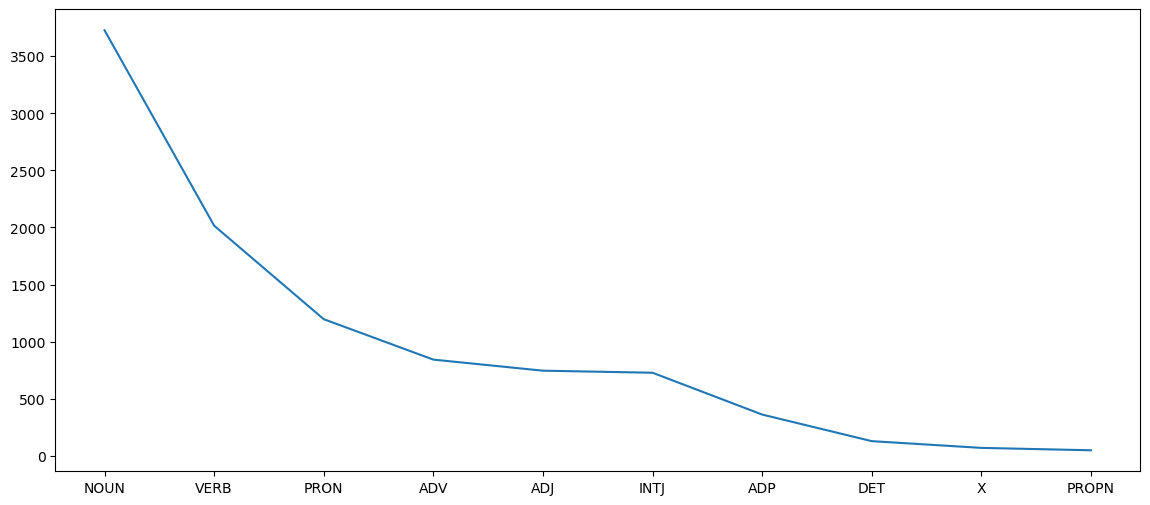

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(top_classes, top_classes_count)

# Preprocessing

First, we need to preprocess our data in order to make it ready for training. The first step is to normalise the text by removing multiple white spaces, and non standard characters.

Since we are training on different embeddings, we need to use a general word slicing process to create our dataset, and then apply any specific tokenization for each model when needed.

This following code serves to generate csv documents each containing the result of the processing of 1024 sentences of the bookcorpus dataset.

We have created 10 000 documents for the training set and 1 000 for the validation and test sets each.

We associate a punctuation to each word in the document.

We keep only the following punctuations:

```python
    "[PERIOD]": [".", "!", ";"],
    "[COMMA]": [",", ":", '"'],
    "[QUESTION]": ["?"],
```

Which leaves us with 4 classes, counting the `[EMPTY]` class that means that a word has no punctuation.

The following code is used to generate the processed dataset.

```python
dataset_train = load_dataset(
    path="bookcorpus", split="train", cache_dir="datasets"
)
punkt_token2symbol = {
    "[PERIOD]": [".", "!", ";"],
    "[COMMA]": [",", ":", '"'],
    "[QUESTION]": ["?"],
}
# creating processed dataset directory
processed_dataset_directory = "processed_dataset_bookcorpus"
if not os.path.isdir(processed_dataset_directory):
    os.mkdir(processed_dataset_directory)

dataset = load_dataset(
    path="bookcorpus", split="train", cache_dir="datasets"
)

text_per_doc = 1024
doc_per_split = {
    "train": 10_000,
    "validation": 1_000,
    "test": 1_000,
}

splits_start_end = {
    "train": {
        "start": 0,
    },
    "validation": {
        "start": doc_per_split["train"],
    },
    "test": {
        "start": doc_per_split["train"] + doc_per_split["validation"],
    }
}

for split in ["train", "validation", "test"]:

    # creating split directory
    processed_split_directory = os.path.join(processed_dataset_directory, split)
    if not os.path.isdir(processed_split_directory):
        os.mkdir(processed_split_directory)

    # for every document in the split
    for doc_idx in tqdm(range(doc_per_split[split]), desc=split):
        words, punctuation = [], []
        processed_docuemnt_path = os.path.join(
            processed_split_directory, f"document{doc_idx}.csv"
        )
        
        start_idx = (splits_start_end[split]["start"] + doc_idx) * text_per_doc
        end_idx = (splits_start_end[split]["start"] + doc_idx + 1) * text_per_doc

        # for every text in the document
        for text_idx in range(start_idx, end_idx):
            text = dataset[text_idx]["text"].lower()

            # spliting words
            text_words = word_tokenize(text, language="english")
            
            # assigning punctuation to words
            for word in text_words:
                # case: period
                if word in punkt_token2symbol["[PERIOD]"]:
                    if len(punctuation) > 0:
                        punctuation[-1] = "[PERIOD]"
                # case: comma
                elif word in punkt_token2symbol["[COMMA]"]:
                    if len(punctuation) > 0:
                        punctuation[-1] = "[COMMA]"
                # case: question
                elif word in punkt_token2symbol["[QUESTION]"]:
                    if len(punctuation) > 0:
                        punctuation[-1] = "[QUESTION]"
                # case: simple word
                elif re.search(r"\w", word):
                    words.append(word)
                    punctuation.append("[EMPTY]")
        
        # writing to csv file
        pd.DataFrame({"words": words, "punctuation": punctuation}).to_csv(
            processed_docuemnt_path, index=False
        )
```

We can take a simple example:

I am John, from Texas.

**World slicing**: [”i”,”am”,”john”,”,”,”from”,”texas”,”.”]

**Punctuation grouping**:

| x  | i        | am       | john    | from     | texas    |
|----|----------|----------|---------|----------|----------|
| y  | [EMPTY ] | [EMPTY ] | [COMMA] | [EMPTY ] | [PERIOD] |



# Training

### Models and layers

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * angular_speed)
        pe[:, 1::2] = torch.cos(position * angular_speed)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, : x.size(1), :]
        return encoded

In [17]:
class LinearClassifierModule(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size):
        super(LinearClassifierModule, self).__init__()
        self.cls = nn.Sequential(
            OrderedDict(
                [
                    ("drop0", nn.Dropout(0.4)),
                    (
                        "linear1",
                        nn.Linear(in_features=embedding_size, out_features=hidden_size),
                    ),
                    ("drop1", nn.Dropout(0.2)),
                    ("relu1", nn.ReLU()),
                    (
                        "linear2",
                        nn.Linear(in_features=hidden_size, out_features=output_size),
                    ),
                ]
            )
        )

    def forward(self, x):
        return self.cls(x)


class LSTMClassifierModule(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size):
        super(LSTMClassifierModule, self).__init__()

        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )
        # self.linear = nn.Linear(in_features=hidden_size * 2, out_features=output_size)
        self.linear = LinearClassifierModule(
            embedding_size=hidden_size * 2,
            hidden_size=hidden_size,
            output_size=output_size,
        )

    def forward(self, x):
        x, (_, _) = self.lstm(x)
        x = self.linear(x)
        return x


class AttnClassifierModule(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, sequence_size):
        super(AttnClassifierModule, self).__init__()
        self.positional_encoding = PositionalEncoding(sequence_size, embedding_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_size, nhead=2, dropout=0.2
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.lstm = LSTMClassifierModule(embedding_size, hidden_size, output_size)

    def forward(self, x, *args, **kwargs):
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.lstm(x)
        return x

In [18]:
class PunctuationRestorationModel(nn.Module):
    def __init__(self, embedding_layer, classifier_layer, is_bert=True):
        super(PunctuationRestorationModel, self).__init__()

        self.is_bert = is_bert
        self.embedding_layer = embedding_layer
        for param in self.embedding_layer.parameters():
            param.requires_grad = False
        self.classifier_layer = classifier_layer

    def forward(self, x, *args, **kwargs):
        if len(x.shape) == 1:
            x = x.view(1, x.shape[0])

        if self.is_bert:
            x = self.embedding_layer(x, *args, **kwargs)[0]
        else:
            x = self.embedding_layer(x, *args, **kwargs)
        x = self.classifier_layer(x)
        return x

## CBOW embedding (trained and pretrained)

#### This is the code that we used to train our word2vec model

```python
nltk.download('punkt')

dataset = load_dataset(
    path="bookcorpus", split="train", cache_dir="datasets"
)

sentences = []
```

#### preprocessing the dataset to get a list of sentences with preprocess_string function

```python
for idx in tqdm(range(20_000_000)):

    item = dataset[idx]
    text = item["text"]
    text_sentences = sent_tokenize(text)

    for sentence in text_sentences:

        sentences.append(preprocess_string(sentence))
```
#### instantiate the  cbow model with 100 dimensions of gensim library
```python
model = Word2Vec(sentences=sentences, vector_size=100, window=5, max_vocab_size=3_000_000)
```
#### save the model
```python
model.wv.save("embedding/word2vec_bookcorpus.model")
```

In [19]:
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    """
    Method to Save a Vocabulary from Pre-trained Embeddings on Disk  as a plain-text file
    """
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    words = wv.index_to_key
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words
    with open(os.path.join(folder, "vocab.txt"), "w") as f:
        for word in words:
            f.write(f"{word}\n")

In [20]:
batch_size = 16
n_epochs = 8
documents_limit = 6

output_size = len(punctuation_token2id)
sequence_size = 128

device = "cuda" if torch.cuda.is_available() else "cpu"
loss_weight = torch.tensor([1.0, 10.0, 20.0, 100.0]).to(device)

lr = 2e-5
weight_decay = 2e-2

In [21]:
# load of the trained model word2vec
w2v_trained = KeyedVectors.load(
    "/kaggle/input/cbow-embedding/embedding/word2vec_bookcorpus.model"
)
# make of the vocabulary from the trained model word2vec by adding special tokens not include in the model
make_vocab_from_wv(
    w2v_trained,
    "trained_vocab.txt",
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"],
)
# load of the pretrained model word2vec
w2v_pretrained = KeyedVectors.load(
    "/kaggle/input/cbow-embedding/embedding/word2vec_pretrained.model"
)
# make of the vocabulary from the pretrained model word2vec by adding special tokens not include in the model
make_vocab_from_wv(
    w2v_pretrained,
    "pretrained_vocab.txt",
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"],
)

Here  we define the different cbow models and 
we use the BertTokenizer class to create a tokenizer
based on the vocabulary of the trained model word2vec(cbow) and 
the pretrained model word2vec(cbow).

We also define the embedding layer of the model based on the
word2vec(cbow) trained and pretrained model.
We also define the embedding size and the hidden size of the model.

In [22]:
cbow = {
    "trained": {
        "tokenizer": BertTokenizer.from_pretrained("trained_vocab.txt"),
        "embedding_layer": nn.Embedding.from_pretrained(
            torch.as_tensor(w2v_trained.vectors).float()
        ),
        "embedding_size": 100,
        "hidden_size": 64,
    },
    "pretrained": {
        "tokenizer": BertTokenizer.from_pretrained("pretrained_vocab.txt"),
        "embedding_layer": nn.Embedding.from_pretrained(
            torch.as_tensor(w2v_pretrained.vectors).float()
        ),
        "embedding_size": 300,
        "hidden_size": 128,
    },
}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Here we define the different models that we want to train.

We define the model name, the model class and the model parameters.

We also define the optimizer and the scheduler.

So we used the differents versions of cbow( trained and pretrained) as
embedding layer of the model. and as a classifier layer we used the
LSTM and transformer.

data loading execution time: 46.6256148815155s


=== Training cbow trained using lstm:
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.3758495348 |         1.3637024089
accuracy             |         0.0591867607 |         0.0579431317
f1-score             |         0.0516458905 |         0.0372938495
execution time (s)   |        43.8190667629 |        25.7957479954
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.3731449362 |         1.3652680825
accuracy             |         0.0530379380 |         0.0579026687
f1-score             |         0.039342782

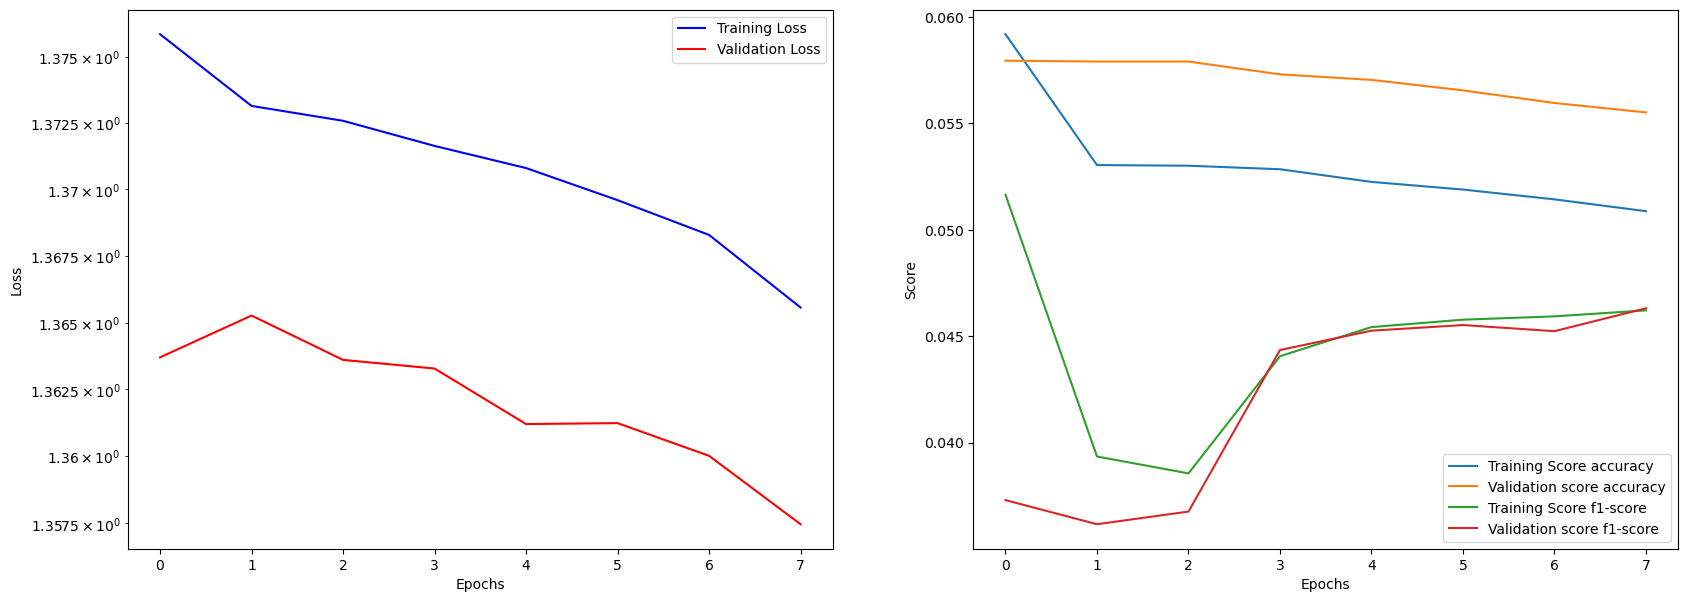



=== Training cbow trained using attention:
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.3754554766 |         1.3614256657
accuracy             |         0.1342462765 |         0.0587807763
f1-score             |         0.0578764789 |         0.0446228706
execution time (s)   |        56.3575515747 |        31.6139607430
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.3596079723 |         1.3300029865
accuracy             |         0.0522251871 |         0.0523124234
f1-score             |         0.0525079711 |         0.0474535114
execution time (s

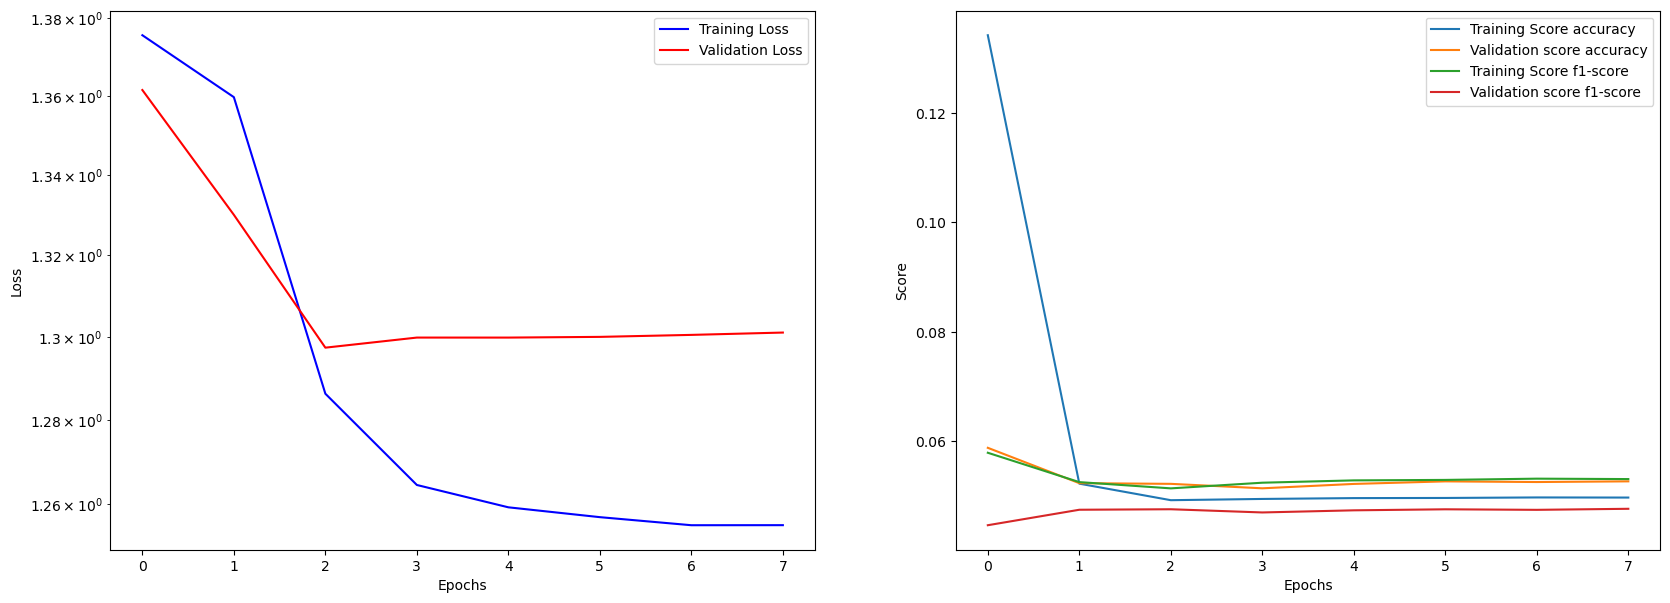

data loading execution time: 50.012526750564575s


=== Training cbow pretrained using lstm:
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.3837251186 |         1.3749547866
accuracy             |         0.0496142925 |         0.0578464067
f1-score             |         0.0337843744 |         0.0361074058
execution time (s)   |        47.7286918163 |        31.9604885578
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.3820943208 |         1.3730232711
accuracy             |         0.0529542818 |         0.0578464067
f1-score             |         0.0335

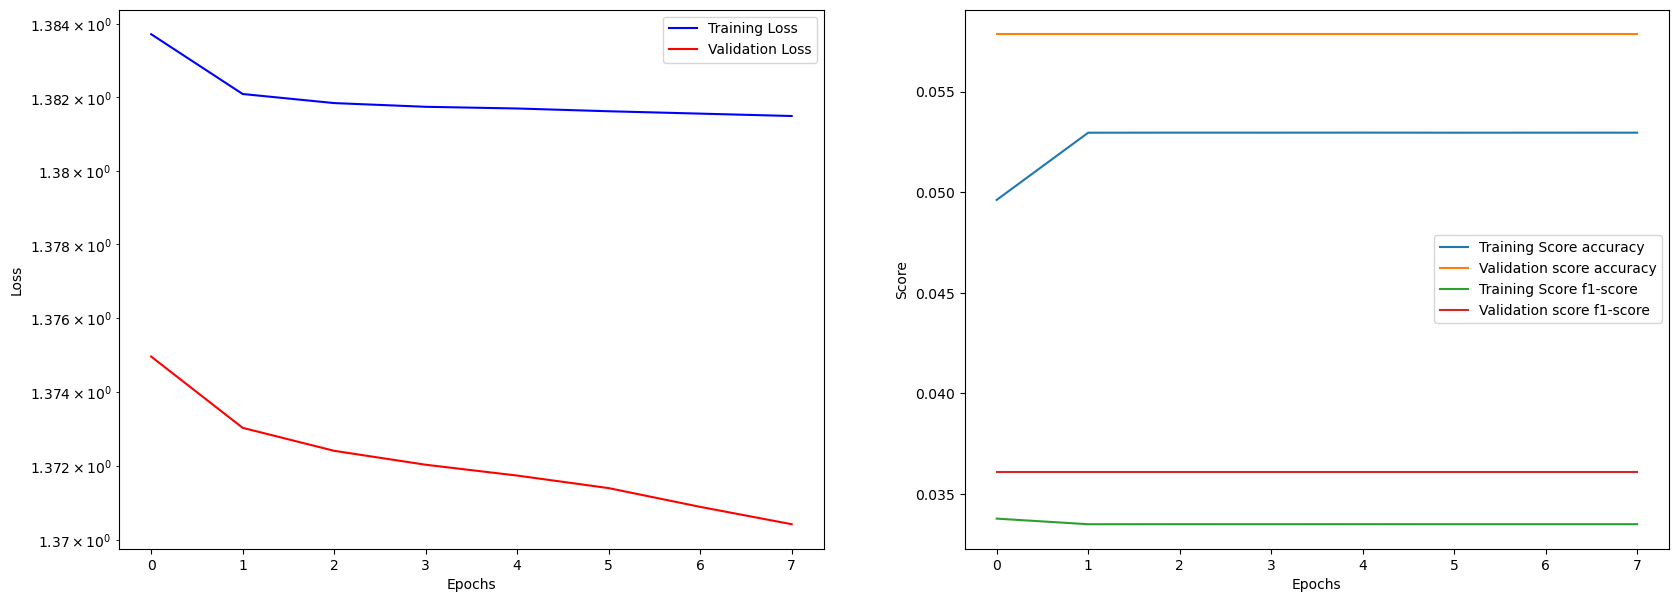



=== Training cbow pretrained using attention:
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.2484201783 |         1.1468553665
accuracy             |         0.5663058020 |         0.5730482216
f1-score             |         0.1028516181 |         0.0804303152
execution time (s)   |        73.2551319599 |        42.0651400089
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.0456005213 |         1.1369328460
accuracy             |         0.5691100888 |         0.5609043530
f1-score             |         0.1082824625 |         0.0826078058
execution time

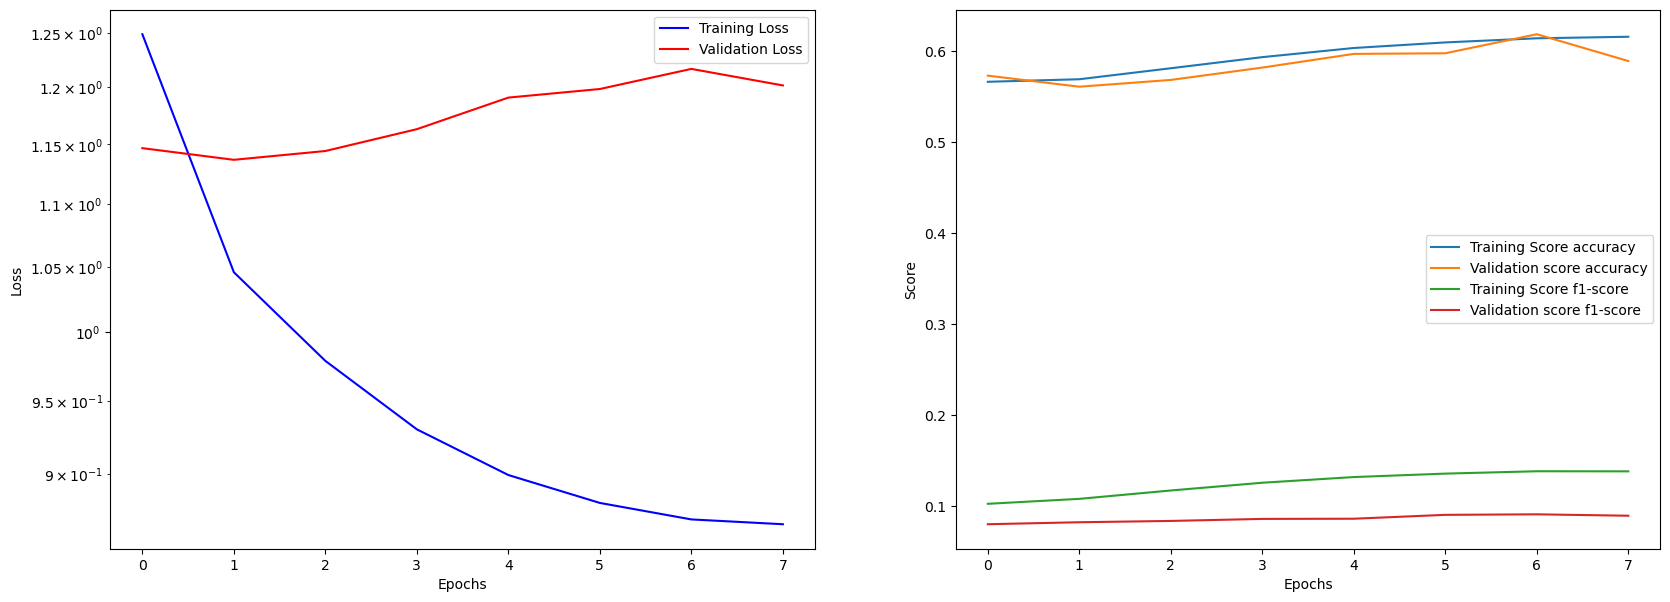

In [23]:
for setting_name in cbow:
    tokenizer = cbow[setting_name]["tokenizer"]
    embedding_layer = cbow[setting_name]["embedding_layer"]
    embedding_size = cbow[setting_name]["embedding_size"]
    hidden_size = cbow[setting_name]["hidden_size"]

    time_start = time.time()
    # creating the training and validation dataset
    train_data = CorpusDataset(
        dir=os.path.join(dataset_path, "train"),
        tokenizer=tokenizer,
        sequence_len=sequence_size,
        documents_limit=documents_limit,
    )
    val_data = CorpusDataset(
        dir=os.path.join(dataset_path, "validation"),
        tokenizer=tokenizer,
        sequence_len=sequence_size,
        documents_limit=documents_limit,
    )

    # creating the training and validation dataloaders
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)
    time_end = time.time()
    print("data loading execution time: {}s".format(time_end - time_start))

    model_cbow_lstm = PunctuationRestorationModel(
        embedding_layer=embedding_layer,
        classifier_layer=LSTMClassifierModule(embedding_size, hidden_size, output_size),
        is_bert=False,
    )
    loss_fn = nn.CrossEntropyLoss(weight=loss_weight)
    optimizer = torch.optim.Adam(
        model_cbow_lstm.parameters(), lr=lr, weight_decay=weight_decay
    )

    wrapper_cbow_lstm = Wrapper(
        model_cbow_lstm, loss_fn, optimizer, use_attention=False
    )

    print(f"\n\n=== Training cbow {setting_name} using lstm:")
    wrapper_cbow_lstm.set_loaders(
        train_loader=train_dataloader, val_loader=val_dataloader
    )
    wrapper_cbow_lstm.train(n_epochs=n_epochs, metrics=[accuracy_metric, f1_metric])

    wrapper_cbow_lstm.report(masked_f1)

    wrapper_cbow_lstm.plot_losses()
    plt.show()

    model_cbow_attn = PunctuationRestorationModel(
        embedding_layer=embedding_layer,
        classifier_layer=AttnClassifierModule(
            embedding_size, hidden_size, output_size, sequence_size
        ),
        is_bert=False,
    )
    loss_fn = nn.CrossEntropyLoss(weight=loss_weight)
    optimizer = torch.optim.Adam(
        model_cbow_attn.parameters(), lr=lr, weight_decay=weight_decay
    )

    wrapper_cbow_attn = Wrapper(
        model_cbow_attn, loss_fn, optimizer, use_attention=False
    )

    print(f"\n\n=== Training cbow {setting_name} using attention:")
    wrapper_cbow_attn.set_loaders(
        train_loader=train_dataloader, val_loader=val_dataloader
    )
    wrapper_cbow_attn.train(n_epochs=n_epochs, metrics=[accuracy_metric, f1_metric])

    wrapper_cbow_attn.report(masked_f1)

    wrapper_cbow_attn.plot_losses()
    plt.show()

As we can see, we notice that the trained cbow + lstm model is better than the pre-trained cbow +lstm model (based on f1 score).

While the cbow pre-trained + attention model is better than the trained + attention model (based on f1 score). The loss of the different models decreases while the scores increase. On the other hand, we notice that the models do not generalise the comma and the questions.  This will often result in commas or questions being ignored in the predict text or added where they should not be.  

## BERT-like embedding

In this part, we will use contextual embedding generated by a bert pretrained model.

We will experiment with several bert-like models varying in complexity and size.

During training, the embedding layer's weights are frozen and we learn only the classification layers weights.

We will first try to select an embedding layer from the pretrained bert models, then we will try to improve on the obtained results by using attention in the classification layer.

Each class is given a weigth proportional to it's frequency, so that we help the model give more importance to rare punctuation marks.

The models usually overfit a lot the training data, we observed a great different between the train and validation results, and this is why we use such a large L2 regularization.

The classification layer size varies depending on the embedding size of each bert model.

In [24]:
settings = {
    "bert-tiny": {
        "tokenizer": BertTokenizer.from_pretrained("prajjwal1/bert-tiny"),
        "embedding_layer": BertModel.from_pretrained("prajjwal1/bert-tiny"),
        "embedding_size": 128,
        "hidden_size": 64,
    },
    "bert-base-uncased": {
        "tokenizer": BertTokenizer.from_pretrained("bert-base-uncased"),
        "embedding_layer": BertModel.from_pretrained("bert-base-uncased"),
        "embedding_size": 768,
        "hidden_size": 128,
    },
    "distilbert-base-uncased": {
        "tokenizer": DistilBertTokenizer.from_pretrained("distilbert-base-uncased"),
        "embedding_layer": DistilBertModel.from_pretrained("distilbert-base-uncased"),
        "embedding_size": 768,
        "hidden_size": 128,
    },
}

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Each model is trained on 6 documents of 1024 sentences each, for 5 epochs. The validation set contains the same number of documents and sentences.

For each embedding layer, we use it's corresponding tokenizer to preprocess the words in the dataset.

data loading execution time: 48.36806893348694s


=== Training bert-tiny:
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.3336749335 |         1.1581732697
accuracy             |         0.3663349429 |         0.6624500686
f1-score             |         0.1095011308 |         0.1175201626
execution time (s)   |        56.1695747375 |        37.9209403992
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.1423073311 |         1.0608604407
accuracy             |         0.6287744415 |         0.6550373208
f1-score             |         0.1608529438 |         0

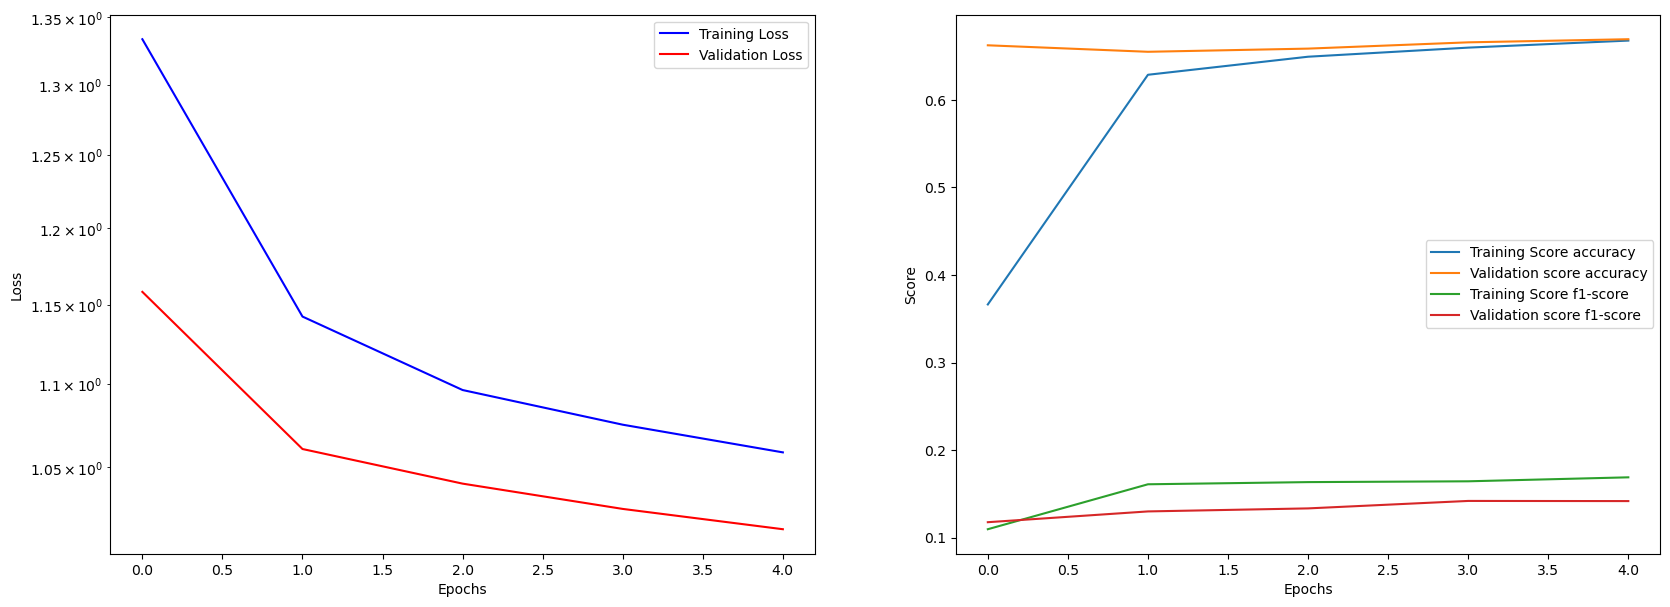

data loading execution time: 48.83382797241211s


=== Training bert-base-uncased:
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.0579463330 |         0.7933802842
accuracy             |         0.5703432611 |         0.8028110300
f1-score             |         0.1958089189 |         0.2743113006
execution time (s)   |       322.2206835747 |       352.1879572868
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         0.7007570446 |         0.7290171319
accuracy             |         0.8211393925 |         0.8431015086
f1-score             |         0.3915218237 |  

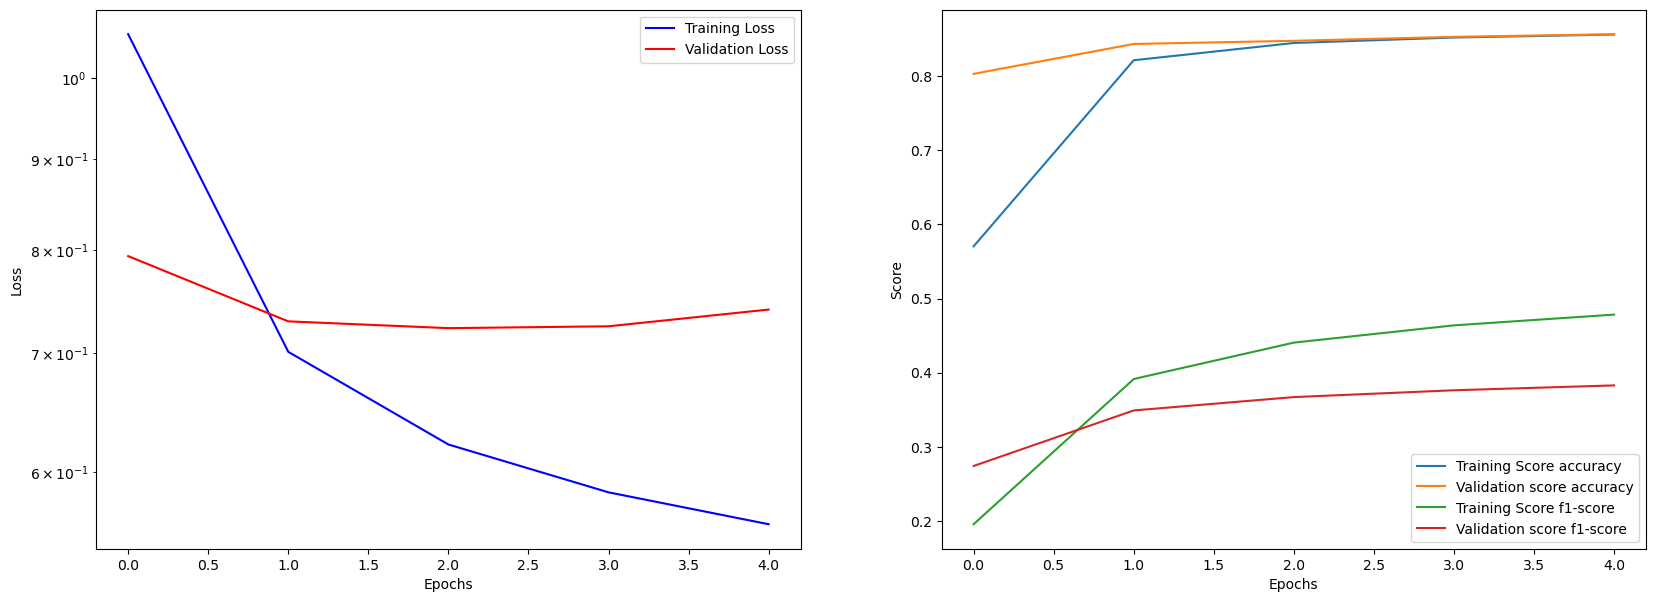

data loading execution time: 48.1818106174469s


=== Training distilbert-base-uncased:
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.1343693704 |         0.8924913721
accuracy             |         0.5202423607 |         0.7326190309
f1-score             |         0.1358202882 |         0.1716790567
execution time (s)   |       188.7329277992 |       193.0605039597
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         0.8049405540 |         0.8204046091
accuracy             |         0.7673878827 |         0.7972546643
f1-score             |         0.294173464

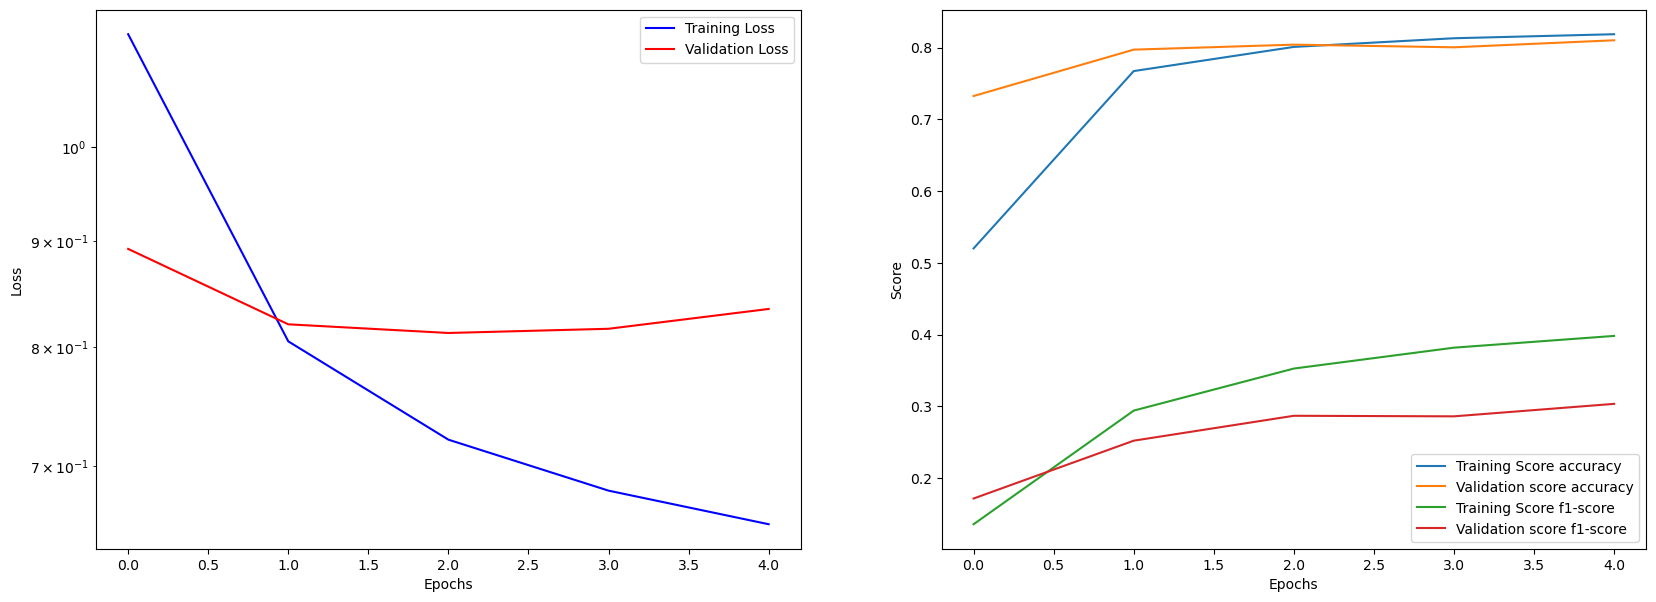

In [25]:
n_epochs = 5

for setting_name in settings:
    tokenizer = settings[setting_name]["tokenizer"]
    embedding_layer = settings[setting_name]["embedding_layer"]
    embedding_size = settings[setting_name]["embedding_size"]
    hidden_size = settings[setting_name]["hidden_size"]

    # creating the training and validation datasets using the corresponding tokenizer
    time_start = time.time()
    train_data = CorpusDataset(
        dir=os.path.join(dataset_path, "train"),
        tokenizer=tokenizer,
        sequence_len=sequence_size,
        documents_limit=documents_limit,
    )
    val_data = CorpusDataset(
        dir=os.path.join(dataset_path, "validation"),
        tokenizer=tokenizer,
        sequence_len=sequence_size,
        documents_limit=documents_limit,
    )

    # creating the training and validation dataloaders
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)
    time_end = time.time()
    print("data loading execution time: {}s".format(time_end - time_start))

    # creating the model with the corresponding embedding and classification layers
    model_bert_lstm = PunctuationRestorationModel(
        embedding_layer=embedding_layer,
        classifier_layer=LSTMClassifierModule(embedding_size, hidden_size, output_size),
    )
    loss_fn = nn.CrossEntropyLoss(weight=loss_weight)
    optimizer = torch.optim.Adam(
        model_bert_lstm.parameters(), lr=lr, weight_decay=weight_decay
    )

    wrapper_bert_lstm = Wrapper(model_bert_lstm, loss_fn, optimizer, use_attention=True)

    print(f"\n\n=== Training {setting_name}:")
    wrapper_bert_lstm.set_loaders(
        train_loader=train_dataloader, val_loader=val_dataloader
    )
    wrapper_bert_lstm.train(n_epochs=n_epochs, metrics=[accuracy_metric, f1_metric])

    wrapper_bert_lstm.report(masked_f1)

    wrapper_bert_lstm.plot_losses()
    plt.show()

From the precedent results, we observe the following:

- The best model overall, f1 score wise, is the bert base model with 43% score followed by distilbert at 35% and bert-tiny with 15%.
  
- This model takes also the largest time for training, around 12min per epoch, whereas distilbert takes only half, and bert-tiny takes just more than a minute.

- There is a small amount of overfitting, thanks to the large dropout ratio in the models and to the large l2 regularization ratio.

In what follows, we try to improve on the previous results by using a larger classification layer with bert embedding layer.

We will use an attention encoder before the precedent lstm layer.

In [26]:
setting_name = "bert-base-uncased"
tokenizer = settings[setting_name]["tokenizer"]
embedding_layer = settings[setting_name]["embedding_layer"]
embedding_size = settings[setting_name]["embedding_size"]
hidden_size = settings[setting_name]["hidden_size"]

time_start = time.time()
train_data = CorpusDataset(
    dir=os.path.join(dataset_path, "train"),
    tokenizer=tokenizer,
    sequence_len=sequence_size,
    documents_limit=documents_limit,
)
val_data = CorpusDataset(
    dir=os.path.join(dataset_path, "validation"),
    tokenizer=tokenizer,
    sequence_len=sequence_size,
    documents_limit=documents_limit,
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
time_end = time.time()
print("data loading execution time: {}s".format(time_end - time_start))

data loading execution time: 48.476731061935425s




=== Training bert-base-uncased:
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         0.8806848612 |         0.7288506333
accuracy             |         0.7211834450 |         0.8309267708
f1-score             |         0.2961041409 |         0.3306871347
execution time (s)   |       370.0624892712 |       372.4532575607
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         0.6341208658 |         0.7048001557
accuracy             |         0.8391773932 |         0.8500348637
f1-score             |         0.4332330284 |         0.3809007009
execution time (s)   |      

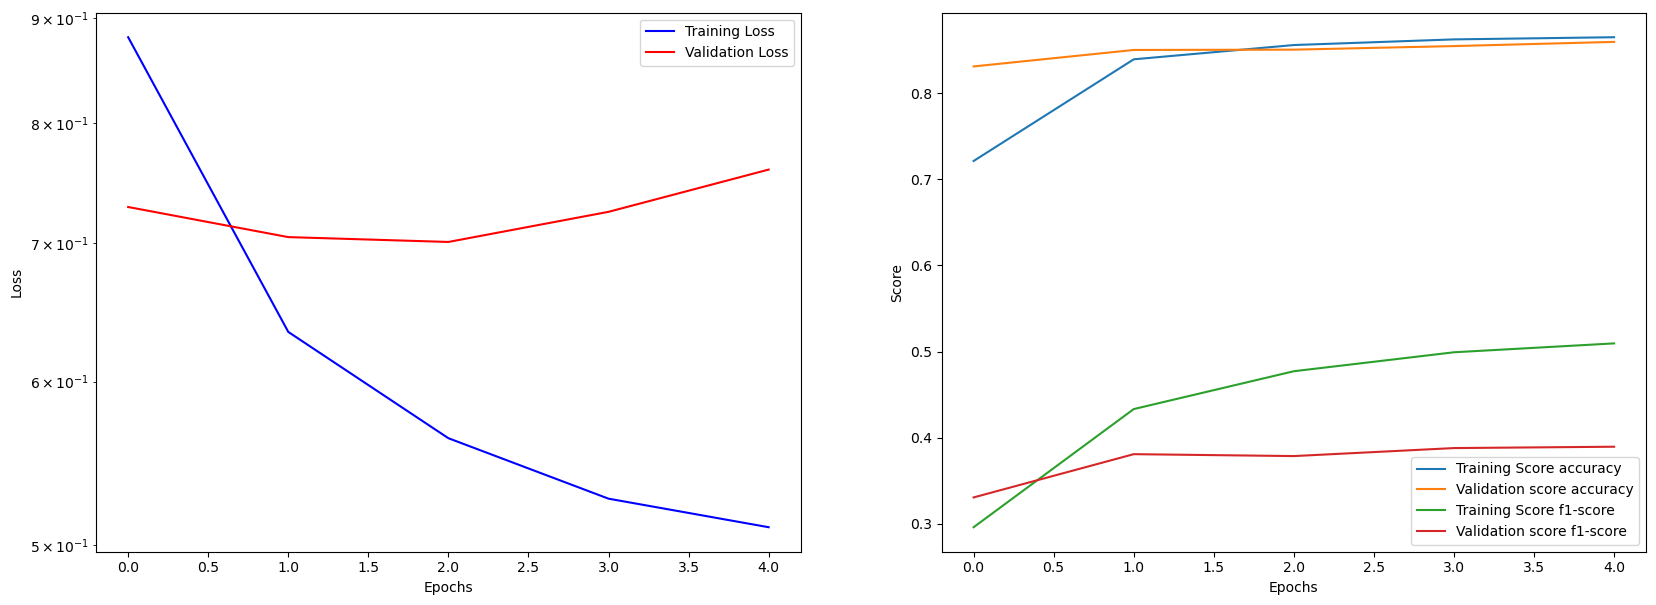

In [27]:
model_bert_attn = PunctuationRestorationModel(
    embedding_layer=embedding_layer,
    classifier_layer=AttnClassifierModule(
        embedding_size, hidden_size, output_size, sequence_size
    ),
)
loss_fn = nn.CrossEntropyLoss(weight=loss_weight)
optimizer = torch.optim.Adam(
    model_bert_attn.parameters(), lr=lr, weight_decay=weight_decay
)

wrapper_bert_attn = Wrapper(model_bert_attn, loss_fn, optimizer, use_attention=True)

print(f"\n\n=== Training {setting_name}:")
wrapper_bert_attn.set_loaders(train_loader=train_dataloader, val_loader=val_dataloader)
wrapper_bert_attn.train(n_epochs=n_epochs, metrics=[accuracy_metric, f1_metric])

wrapper_bert_attn.report(masked_f1)

wrapper_bert_attn.plot_losses()
plt.show()

After 5 epochs of training, we reached a better score of 45%.

training bert-base-uncased for documents limit = 2...
------------------------------------------------------------------
                   0 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.3406660285 |         1.2080339792
accuracy             |         0.1556994084 |         0.6565144420
f1-score             |         0.0699312213 |         0.1068386681
execution time (s)   |        97.8720207214 |       131.6329236031
------------------------------------------------------------------
------------------------------------------------------------------
                   1 | train scores         | validation scores   
------------------------------------------------------------------
loss                 |         1.0092803717 |         0.9157312212
accuracy             |         0.6406017024 |         0.7455463213
f1-score             |         0.2024588469 |         0.1938954003
executio

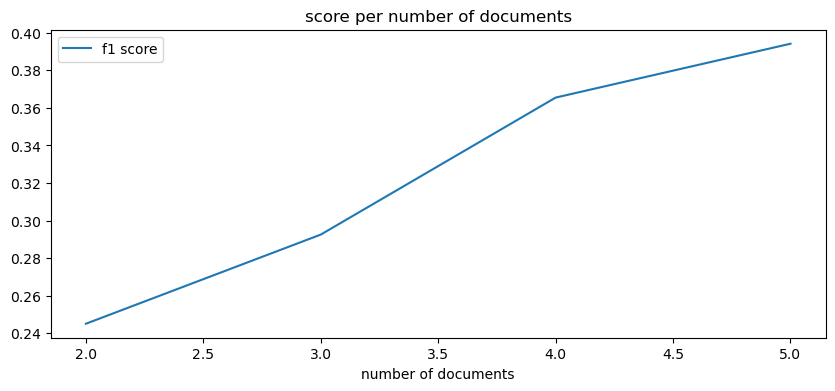

In [28]:
def learning_curve(setting_name, n_documents=[2, 3, 4, 5], n_epochs=2):
    scores = []
    for documents_limit in n_documents:
        tokenizer = settings[setting_name]["tokenizer"]
        embedding_layer = settings[setting_name]["embedding_layer"]
        embedding_size = settings[setting_name]["embedding_size"]
        hidden_size = settings[setting_name]["hidden_size"]

        train_data = CorpusDataset(
            dir=os.path.join(dataset_path, "train"),
            tokenizer=tokenizer,
            sequence_len=sequence_size,
            documents_limit=documents_limit,
        )
        val_data = CorpusDataset(
            dir=os.path.join(dataset_path, "validation"),
            tokenizer=tokenizer,
            sequence_len=sequence_size,
            documents_limit=documents_limit,
        )

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=batch_size)

        model = PunctuationRestorationModel(
            embedding_layer=embedding_layer,
            classifier_layer=LSTMClassifierModule(
                embedding_size, hidden_size, output_size
            ),
        )
        loss_fn = nn.CrossEntropyLoss(weight=loss_weight)
        optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, weight_decay=weight_decay
        )

        wrapper = Wrapper(model, loss_fn, optimizer, use_attention=True)
        print(f"training {setting_name} for documents limit = {documents_limit}...")
        wrapper.set_loaders(train_loader=train_dataloader, val_loader=val_dataloader)
        wrapper.train(n_epochs=n_epochs, metrics=[accuracy_metric, f1_metric])

        scores.append(wrapper.score(masked_f1))

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(n_documents, scores, label="f1 score")
    ax.set_xlabel("number of documents")
    ax.set_ylabel("")
    ax.legend()
    ax.set_title("score per number of documents")
    fig.show()


learning_curve(setting_name)

From the learning curve, we observe that the size of the training set is positively correlated with the performances.

We can safely conclude that by adding more data to our training set (larger number of documents) and by using larger training times, we will increase the performances of the model to eventually reach the performances reported in the reference papers.

In [29]:
setting_name = "bert-base-uncased"
tokenizer = settings[setting_name]["tokenizer"]
embedding_layer = settings[setting_name]["embedding_layer"]
embedding_size = settings[setting_name]["embedding_size"]
hidden_size = settings[setting_name]["hidden_size"]

test_data = CorpusDataset(
    dir=os.path.join(dataset_path, "test"),
    tokenizer=tokenizer,
    sequence_len=sequence_size,
    documents_limit=documents_limit,
)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

best_model_wrapper = wrapper_bert_attn
best_model_wrapper.val_loader = test_dataloader
print("Test score is:", best_model_wrapper.score(masked_f1))

Test score is: 0.48065923252952514


Finally, we again test the perfromances of the best model (bert embedding + attention classifier) on the final test set.

We got a result of 48% overall f1 score which indicates that the model did not overfit so much and that the regularization was useful.

<AxesSubplot:>

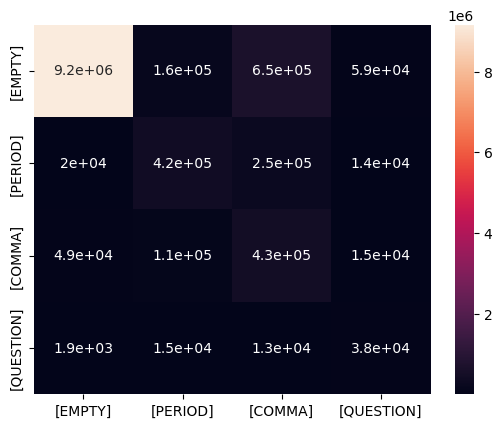

In [30]:
y, y_hat = best_model_wrapper.predict_val()
cm = confusion_matrix(y.flatten(), y_hat.flatten())
sns.heatmap(
    cm,
    annot=True,
    xticklabels=punctuation_token2id.keys(),
    yticklabels=punctuation_token2id.keys(),
)

<AxesSubplot:>

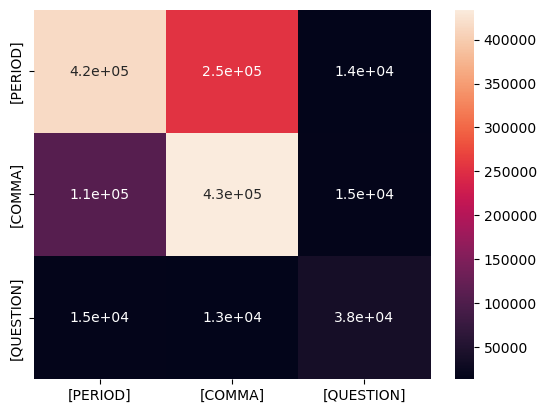

In [31]:
sns.heatmap(
    cm[1:, 1:],
    annot=True,
    xticklabels=list(punctuation_token2id.keys())[1:],
    yticklabels=list(punctuation_token2id.keys())[1:],
)

We see that the model often confuses comma and periods as they usually occupy interchangeable roles in a sentence.

The biggest error rates are in the prediction of the question mark, since it is the least represented punctuation mark in the dataset.

In [32]:
def prediction_to_text(x, y, tokenizer, punkt_dict):
    token2symbol = {
        "[PERIOD]": ".",
        "[COMMA]": ",",
        "[QUESTION]": "?",
    }

    idx = 0
    n_tokens = len(x)
    result = ""
    while idx < n_tokens:
        seq_len = 0
        while True:
            if idx + seq_len == n_tokens - 1 or y[idx + seq_len] > 0:
                seq = tokenizer.decode(x[idx : idx + seq_len + 1])
                if y[idx + seq_len] == 0:
                    punkt = ""
                else:
                    punkt = token2symbol[list(punkt_dict.keys())[y[idx + seq_len]]]
                result += seq + punkt + " "
                idx = idx + seq_len + 1
                break
            else:
                seq_len = seq_len + 1
    return result


x, y, attn, y_m = test_data[0]
x.to("cpu")
attn.to("cpu")
best_model_wrapper.model.to("cpu")
y_hat = best_model_wrapper.model(x, attn.view(1, -1))
x = x.detach().cpu().numpy()
y_hat = y_hat.detach().cpu().numpy()
pred = prediction_to_text(
    x, y_hat.argmax(-1).reshape(-1), tokenizer, punctuation_token2id
)
orig = prediction_to_text(x, y, tokenizer, punctuation_token2id)
print("original text:")
print(orig)
print("\n\n")
print("predicted punctuation:")
print(pred)

original text:
[CLS] the 102nd and 98th will each contribute two frigates towards filling the gaps in the 51st, 144th and 153rd. those three squadrons, along with the 77th, will be redeployed after their crews stand down for a one week rest period. what ultimately will become of the 102nd and 98th has not been decided yet. we may disband those squadrons altogether, or rebuild them with new ships coming off the shipyards, but thats yet to be determined. now, before i dismiss you so that you can get your crews on the ground, its important that we have all after - action reports before you go on r r. if you havent already [SEP] 



predicted punctuation:
[CLS] the 102nd and 98th will each contribute two frigates towards filling the gaps in the 51st, 144th and 153rd. those three squadrons along with the 77th will be redeployed after their crews stand down for a one week rest period, what ultimately will become of the 102nd and 98th has not been decided. yet, we may disband those squadrons 

Overall, in the example, the model finds well sentence endings. Although it confuses comma and periods in several occasions.

# Conclusion

## What we have tried

- We went through the different statistics of our data and visualized their underlying distribution.

- We tried different preprocessing pipelines and selected the best approach for our task.

- We explored different architectures and models, by combining several embeddings and classification layers.

- We evaluated the performances of each model using different metrics and visualized the errors of the best model.

## What we could have done if we had more time

- More data is better, bigger sequence length would help the models too

- Adding another prediction head for POS may help predicting punctuation

- Punctuation marks are rich and doing a high level preliminary prediction of the more frequent punctuation is better than predicting less frequent punctuation (e.g. ‘(’, ‘)’,...)

# References

- [Punctuation Restoration using Transformer Models for High-and Low-Resource Languages](https://aclanthology.org/2020.wnut-1.18.pdf)

- [Automatic punctuation restoration with BERT models](https://arxiv.org/pdf/2101.07343.pdf)

- Deep Learning with PyTorch Step-by-Step. A Beginner's Guide. By Daniel Voigt Godoy

- [Hugging Face models and datasets repository](https://huggingface.co/)